# XGBoost test

This function handles evaluating XGBoost model performance 

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [17]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model
from cloudpickle import load

from mlrun.mlutils import eval_model_v2, gcf_clear

def xgb_test(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    plots_dest: str = "plots",
    default_model: str = "model.pkl"
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     model artifact to be tested
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param plots_dest:      dir for test plots
    :param default_model:   'model.pkl', default model artifact file name
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    try:
        model_file, model_obj, _ = get_model(models_path.url, suffix='.pkl')
        model_obj = load(open(model_file, "rb"))
    except Exception as a:
        raise Exception("model location likely misspecified")

    eval_metrics = eval_model_v2(context, xtest, ytest.values, model_obj)

In [18]:
# nuclio: end-code

### save

In [19]:
from mlrun import code_to_function
from mlrun.platforms.other import auto_mount

gpus = False

fn_params = {
    "name"        : "xgb_test",
    "handler"     : "xgb_test",
    "kind"        : "job",
    "image"       : "mlrun/ml-models" if not gpus else "mlrun/ml-models-gpu",
    "description" : "test a classifier using held-out or new data",
    "categories"  : ["ml", "test"],
    "labels"      : {"author": "yjb", "framework": "xgboost"},
}

fn = code_to_function(**fn_params)

fn.export("function.yaml")
fn.apply(auto_mount())

[mlrun] 2020-06-14 11:34:46,748 function spec saved to path: function.yaml


### test function

In [20]:
task_params = {
    "name" : "tasks xgb test",
    "params": {
        "label_column"  : "labels",
        "plots_dest"    : "plots/xgb_test"}}

In [21]:
from mlrun import mlconf

DATA_PATH  = mlconf.artifact_path+"/xgb/classifier-data.csv"
MODELS_PATH = mlconf.artifact_path+"/xgb/models/model.pkl"

### run locally

[mlrun] 2020-06-14 11:34:47,116 starting run tasks xgb test uid=693918893e4446fcaf3316215e03d741  -> http://mlrun-api:8080
[mlrun] 2020-06-14 11:34:47,325 log artifact probability-calibration at /User/artifacts/plots/probability-calibration.html, size: 26270, db: N
[mlrun] 2020-06-14 11:34:47,467 log artifact confusion-matrix at /User/artifacts/plots/confusion-matrix.html, size: 10257, db: N
[mlrun] 2020-06-14 11:34:47,701 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 8413, db: N
[mlrun] 2020-06-14 11:34:47,808 log artifact precision-recall-binary at /User/artifacts/plots/precision-recall-binary.html, size: 16401, db: N
[mlrun] 2020-06-14 11:34:47,956 log artifact roc-binary at /User/artifacts/plots/roc-binary.html, size: 19753, db: N



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...5e03d741,0,Jun 14 11:34:47,completed,tasks xgb test,v3io_user=adminkind=handlerowner=adminhost=jupyter-7b44c8d958-kklf7,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,accuracy=0.9656test-error=0.0344rocauc=0.9850800418049069brier_score=0.030492313806775233f1-score=0.9653365578395808precision_score=0.9743694060211554recall_score=0.9564696485623003,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary


to track results use .show() or .logs() or in CLI: 
!mlrun get run 693918893e4446fcaf3316215e03d741 --project default , !mlrun logs 693918893e4446fcaf3316215e03d741 --project default
[mlrun] 2020-06-14 11:34:48,015 run executed, status=completed


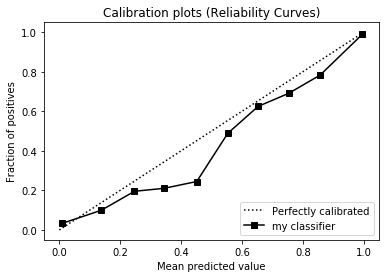

<Figure size 432x288 with 0 Axes>

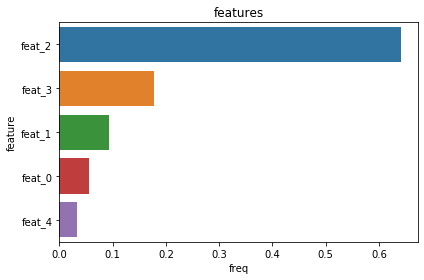

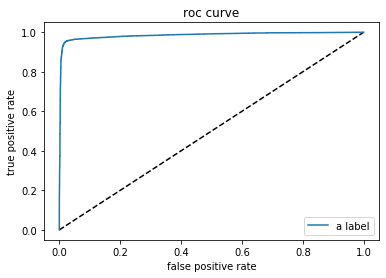

In [22]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=xgb_test,
                inputs={"test_set"      : DATA_PATH,
                        "models_path"   : MODELS_PATH},
                workdir=mlconf.artifact_path)

In [25]:
fn.deploy(skip_deployed=True, with_mlrun=False)

run = fn.run(
    NewTask(**task_params),
    inputs={"test_set"      : DATA_PATH,
            "models_path"   : MODELS_PATH
        },
    workdir=mlconf.artifact_path)

[mlrun] 2020-06-14 11:35:08,097 starting run tasks xgb test uid=2ce7dd9f46914295bddc0507cf1bd4e8  -> http://mlrun-api:8080
[mlrun] 2020-06-14 11:35:08,199 Job is running in the background, pod: tasks-xgb-test-c5vwj
[mlrun] 2020-06-14 11:35:11,671 starting local run: main.py # xgb_test
[mlrun] 2020-06-14 11:35:13,076 log artifact probability-calibration at /User/artifacts/plots/probability-calibration.html, size: 49398, db: N
[mlrun] 2020-06-14 11:35:13,261 log artifact confusion-matrix at /User/artifacts/plots/confusion-matrix.html, size: 18913, db: N
[mlrun] 2020-06-14 11:35:13,467 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 18029, db: N
[mlrun] 2020-06-14 11:35:13,589 log artifact precision-recall-binary at /User/artifacts/plots/precision-recall-binary.html, size: 31309, db: N
[mlrun] 2020-06-14 11:35:13,720 log artifact roc-binary at /User/artifacts/plots/roc-binary.html, size: 37293, db: N

[mlrun] 2020-06-14 11:35:13,752 run executed, 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...cf1bd4e8,0,Jun 14 11:35:12,completed,tasks xgb test,v3io_user=adminkind=jobowner=adminhost=tasks-xgb-test-c5vwj,test_setmodels_path,label_column=labelsplots_dest=plots/xgb_test,accuracy=0.9656test-error=0.0344rocauc=0.9850800418049069brier_score=0.03049231380676565f1-score=0.9653365578395808precision_score=0.9743694060211554recall_score=0.9564696485623003,probability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binary


to track results use .show() or .logs() or in CLI: 
!mlrun get run 2ce7dd9f46914295bddc0507cf1bd4e8 --project default , !mlrun logs 2ce7dd9f46914295bddc0507cf1bd4e8 --project default
[mlrun] 2020-06-14 11:35:17,441 run executed, status=completed
